<a href="https://colab.research.google.com/github/SalvatoreMessina11/ARM-valuation/blob/main/arm_intrinsic_valuation_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title 1) Setup: Parameters & Core Functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# — Financial parameters —
rf, erp            = 0.0443, 0.0631
debt, equity, cash = 0.346, 6.839, 2.825
shares             = 1.066
roic_target        = 0.12

# — Time horizon & base revenue —
start_year, end_year = 2026, 2036
years                = np.arange(start_year, end_year+1)
m                    = len(years)
rev0                 = 4.007*1.17   # actual 2026 revenue

# — Historic R&D & useful life —
hist_rd = [0.814, 0.995, 1.133, 1.979, 2.071]
n_rd    = 10

def converge(arr, k, target, start):
    out = arr.copy()
    for i in range(start, len(out)):
        out[i] = out[i-1] + k*(target[i] - out[i-1])
    return out

def compute_projection(horizon, omat=0.50):
    # Growth & volatility
    g = np.zeros(m);    g[:horizon] = 0.17
    g = converge(g,0.5,np.full(m,rf),horizon); g[-1]=rf
    v = np.zeros(m);    v[:horizon] = 0.127
    v = converge(v,0.5,np.full(m,0.0177),horizon); v[-1]=0.0177
    # Tax
    t = np.full(m,0.15); t[:horizon]=0.10
    # Revenue
    rev = np.zeros(m); rev[0]=rev0
    for i in range(1,m):
        rev[i]=rev[i-1]*(1+g[i])
    # NOPAT
    ebit  = rev*omat
    nopat = ebit*(1-t)
    # WACC & DF
    b = np.full(m, 1.3175)
    Re = rf + b * erp
    rd = 0.02565
    wacc = (equity / (equity + debt)) * Re + (debt / (equity + debt)) * rd
    target_wacc = roic_target - 0.02  # or set to 0.1 directly
    wacc = converge(wacc, 0.25, np.full(m, target_wacc), horizon)
    wacc[-1] = target_wacc
    df   = np.zeros(m); df[0]=1/(1+wacc[0])
    for i in range(1,m):
        df[i]=df[i-1]/(1+wacc[i])
    return {'g':g,'v':v,'t':t,'rev':rev,'nopat':nopat,'wacc':wacc,'df':df}

def compute_rd_series(horizon, omat_pre_tax=0.50):
    proj = compute_projection(horizon, omat=omat_pre_tax)
    rev  = proj['rev']
    # — Dilution —
    dil = np.zeros(m)
    dil[:horizon] = 0.03
    dil = converge(dil, 0.5, np.full(m, 0.01), horizon)
    dil[-1] = 0.01

    # — Book Equity (BVE) —
    BVE = np.zeros(m)
    BVE[0] = equity + rev0*0.03
    for i in range(1, m):
        BVE[i] = BVE[i-1] + rev[i-1] * dil[i-1]

    # — R&D % & outlay —
    omt0   = omat_pre_tax if np.isscalar(omat_pre_tax) else omat_pre_tax[0]
    p0     = 0.5 * (1 - omt0)
    p_star = min(0.05, 0.1 * (1 - omt0))
    rd_pct = np.zeros(m)
    rd_pct[:horizon] = p0
    rd_pct = converge(rd_pct, 0.5, np.full(m, p_star), horizon)
    rd_pct[-1] = p_star

    rd = rd_pct * rev

    # — CapRD & Amort (con lag sugli storici) —
    w_cap = [(n_rd - k) / n_rd for k in range(n_rd+1)]
    w_am  = [0.0] + [1/n_rd] * n_rd
    caprd = np.zeros(m)
    amort = np.zeros(m)

    for i in range(m):
        lags = []
        for k in range(n_rd+1):
            j = i - k
            if j >= 0:
                lags.append(rd[j])
            else:
                # j<0 → prendi da hist_rd: j=-1 → ultimo elemento (2025), j=-2 → secondo da ultimo (2024), …
                hi = len(hist_rd) + j
                lags.append(hist_rd[hi] if 0 <= hi < len(hist_rd) else 0.0)
        caprd[i] = sum(w_cap[k] * lags[k] for k in range(n_rd+1))
        amort[i] = sum(w_am[k]  * lags[k] for k in range(n_rd+1))

    # — Invested Capital —
    ic = BVE + caprd + debt - cash

    # — Adjusted metrics —
    net_rd    = rd - amort
    adj_np    = proj['nopat'] + net_rd
    adj_roic  = np.full(m, np.nan); adj_roic[1:] = adj_np[1:] / ic[:-1]
    adj_omat  = np.full(m, np.nan); adj_omat = adj_np / rev

    return {
        **proj,
        'dilution': dil,
        'BVE':       BVE,
        'rd_pct':    rd_pct,
        'rd':        rd,
        'caprd':     caprd,
        'amort':     amort,
        'ic':        ic,
        'adj_nopat': adj_np,
        'adj_roic':  adj_roic,
        'adj_omat':  adj_omat
    }


In [11]:
#@title 2) Detailed FCFF Projection (2026–2036)
for lbl, h in [('7-Year Growth', 7), ('5-Year Growth', 5)]:
    proj = compute_projection(h)   # NON pd.DataFrame(…)
    df = pd.DataFrame({
        'Revenue':       proj['rev'],
        'Growth':        proj['g'],
        'Volatility':    proj['v'],
        'OM':  np.full(m, 0.50),
        'Tax Rate':      proj['t'],
        'NOPAT':         proj['nopat'],
        'WACC':          proj['wacc'],
        'Discount F.':   proj['df'],
        'PV FCFF':       proj['nopat'] * proj['df']
    }, index=years)
    print(f"### FCFF Projection ({lbl})")
    display(df.T)


### FCFF Projection (7-Year Growth)


,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036
Revenue,4.688190,5.485182,6.417663,7.508666,8.785139,10.278613,12.025977,13.314561,14.322806,15.182353,15.854931
Growth,0.170000,0.170000,0.170000,0.170000,0.170000,0.170000,0.170000,0.107150,0.075725,0.060012,0.044300
Volatility,0.127000,0.127000,0.127000,0.127000,0.127000,0.127000,0.127000,0.072350,0.045025,0.031363,0.017700
OM,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Tax Rate,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.150000,0.150000,0.150000,0.150000
NOPAT,2.109685,2.468332,2.887948,3.378900,3.953313,4.625376,5.411690,5.658688,6.087192,6.452500,6.738346
WACC,0.122533,0.122533,0.122533,0.122533,0.122533,0.122533,0.122533,0.116900,0.112675,0.109506,0.100000
Discount F.,0.890843,0.793601,0.706973,0.629802,0.561054,0.499811,0.445253,0.398651,0.358282,0.322920,0.293564
PV FCFF,1.879398,1.958870,2.041702,2.128037,2.218023,2.311814,2.409571,2.255841,2.180929,2.083641,1.978133


### FCFF Projection (5-Year Growth)


,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036
Revenue,4.688190,5.485182,6.417663,7.508666,8.785139,9.726467,10.463004,11.090915,11.669375,12.232167,12.774052
Growth,0.170000,0.170000,0.170000,0.170000,0.170000,0.107150,0.075725,0.060012,0.052156,0.048228,0.044300
Volatility,0.127000,0.127000,0.127000,0.127000,0.127000,0.072350,0.045025,0.031363,0.024531,0.021116,0.017700
OM,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Tax Rate,0.100000,0.100000,0.100000,0.100000,0.100000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000
NOPAT,2.109685,2.468332,2.887948,3.378900,3.953313,4.133748,4.446777,4.713639,4.959484,5.198671,5.428972
WACC,0.122533,0.122533,0.122533,0.122533,0.122533,0.116900,0.112675,0.109506,0.107129,0.105347,0.100000
Discount F.,0.890843,0.793601,0.706973,0.629802,0.561054,0.502332,0.451463,0.406905,0.367531,0.332503,0.302276
PV FCFF,1.879398,1.958870,2.041702,2.128037,2.218023,2.076514,2.007557,1.918003,1.822767,1.728575,1.641046


In [12]:
#@title 2.2) R&D Debug (CAPRD & Amortization) — selezione colonne specifiche
years_dbg = np.arange(2025, end_year+1)
ks        = list(range(n_rd+1))
w_cap     = [(n_rd - k)/n_rd for k in ks]
w_am      = [0.0] + [1/n_rd]*n_rd

for h in [7, 5]:
    print(f"### CAPRD Debug: {h}-Year (2025–2036)")
    s = compute_rd_series(h)

    rows_c = []
    for yr in years_dbg:
        rd_lags = []
        for k in ks:
            target = yr - k
            if target >= 2026:
                rd_lags.append(s['rd'][target-2026])
            elif 2021 <= target <= 2025:
                rd_lags.append(hist_rd[target-2021])
            else:
                rd_lags.append(0.0)
        cap_val = sum(w_cap[k]*rd_lags[k] for k in ks)
        rows_c.append([yr, cap_val] + w_cap + rd_lags)

    cols_w     = [f'w_{k}' for k in ks]
    cols_lags  = [f'rd_lag_{k}' for k in ks]
    df_c_full  = pd.DataFrame(rows_c, columns=['Year','CapRD'] + cols_w + cols_lags)

    # colonne da mostrare per CapRD
    cols_show_c = ['Year','CapRD','w_0','w_1','w_2','w_9','w_10'] + cols_lags
    display(df_c_full[cols_show_c])

    print(f"### Amort Debug: {h}-Year (2025–2036)")
    rows_a = []
    for yr in years_dbg:
        rd_lags = []
        for k in ks:
            target = yr - k
            if target >= 2026:
                rd_lags.append(s['rd'][target-2026])
            elif 2021 <= target <= 2025:
                rd_lags.append(hist_rd[target-2021])
            else:
                rd_lags.append(0.0)
        amort_val = sum(w_am[k]*rd_lags[k] for k in ks)
        rows_a.append([yr, amort_val] + w_am + rd_lags)

    df_a_full = pd.DataFrame(rows_a, columns=['Year','Amort'] + cols_w + cols_lags)

    # colonne da mostrare per Amort
    cols_show_a = ['Year','Amort','w_0','w_1','w_2','w_9','w_10'] + cols_lags
    display(df_a_full[cols_show_a])


### CAPRD Debug: 7-Year (2025–2036)


,Year,CapRD,w_0,w_1,w_2,w_9,w_10,rd_lag_0,rd_lag_1,rd_lag_2,rd_lag_3,rd_lag_4,rd_lag_5,rd_lag_6,rd_lag_7,rd_lag_8,rd_lag_9,rd_lag_10
0,2025,5.943400,1.0,0.9,0.8,0.1,0.0,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2026,6.416248,1.0,0.9,0.8,0.1,0.0,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2027,6.971138,1.0,0.9,0.8,0.1,0.0,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000
3,2028,7.622020,1.0,0.9,0.8,0.1,0.0,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000
4,2029,8.385210,1.0,0.9,0.8,0.1,0.0,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000
5,2030,9.279803,1.0,0.9,0.8,0.1,0.0,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000
6,2031,10.328135,1.0,0.9,0.8,0.1,0.0,2.569653,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000
7,2032,11.637743,1.0,0.9,0.8,0.1,0.0,3.006494,2.569653,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000
8,2033,11.736891,1.0,0.9,0.8,0.1,0.0,1.997184,3.006494,2.569653,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000
9,2034,11.184718,1.0,0.9,0.8,0.1,0.0,1.432281,1.997184,3.006494,2.569653,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000


### Amort Debug: 7-Year (2025–2036)


,Year,Amort,w_0,w_1,w_2,w_9,w_10,rd_lag_0,rd_lag_1,rd_lag_2,rd_lag_3,rd_lag_4,rd_lag_5,rd_lag_6,rd_lag_7,rd_lag_8,rd_lag_9,rd_lag_10
0,2025,0.492100,0.0,0.1,0.1,0.1,0.1,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2026,0.699200,0.0,0.1,0.1,0.1,0.1,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2027,0.816405,0.0,0.1,0.1,0.1,0.1,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000
3,2028,0.953534,0.0,0.1,0.1,0.1,0.1,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000
4,2029,1.113976,0.0,0.1,0.1,0.1,0.1,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000
5,2030,1.301693,0.0,0.1,0.1,0.1,0.1,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000
6,2031,1.521321,0.0,0.1,0.1,0.1,0.1,2.569653,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000
7,2032,1.696886,0.0,0.1,0.1,0.1,0.1,3.006494,2.569653,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000
8,2033,1.898036,0.0,0.1,0.1,0.1,0.1,1.997184,3.006494,2.569653,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000
9,2034,1.984454,0.0,0.1,0.1,0.1,0.1,1.432281,1.997184,3.006494,2.569653,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000


### CAPRD Debug: 5-Year (2025–2036)


,Year,CapRD,w_0,w_1,w_2,w_9,w_10,rd_lag_0,rd_lag_1,rd_lag_2,rd_lag_3,rd_lag_4,rd_lag_5,rd_lag_6,rd_lag_7,rd_lag_8,rd_lag_9,rd_lag_10
0,2025,5.943400,1.0,0.9,0.8,0.1,0.0,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2026,6.416248,1.0,0.9,0.8,0.1,0.0,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2027,6.971138,1.0,0.9,0.8,0.1,0.0,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000
3,2028,7.622020,1.0,0.9,0.8,0.1,0.0,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000
4,2029,8.385210,1.0,0.9,0.8,0.1,0.0,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000
5,2030,9.279803,1.0,0.9,0.8,0.1,0.0,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000
6,2031,9.217452,1.0,0.9,0.8,0.1,0.0,1.458970,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000
7,2032,8.677934,1.0,0.9,0.8,0.1,0.0,1.046300,1.458970,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000
8,2033,7.918805,1.0,0.9,0.8,0.1,0.0,0.831819,1.046300,1.458970,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000
9,2034,7.087311,1.0,0.9,0.8,0.1,0.0,0.729336,0.831819,1.046300,1.458970,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000


### Amort Debug: 5-Year (2025–2036)


,Year,Amort,w_0,w_1,w_2,w_9,w_10,rd_lag_0,rd_lag_1,rd_lag_2,rd_lag_3,rd_lag_4,rd_lag_5,rd_lag_6,rd_lag_7,rd_lag_8,rd_lag_9,rd_lag_10
0,2025,0.492100,0.0,0.1,0.1,0.1,0.1,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2026,0.699200,0.0,0.1,0.1,0.1,0.1,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2027,0.816405,0.0,0.1,0.1,0.1,0.1,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000,0.000000
3,2028,0.953534,0.0,0.1,0.1,0.1,0.1,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000,0.000000
4,2029,1.113976,0.0,0.1,0.1,0.1,0.1,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000,0.000000
5,2030,1.301693,0.0,0.1,0.1,0.1,0.1,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000,0.000000
6,2031,1.521321,0.0,0.1,0.1,0.1,0.1,1.458970,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000,0.814000
7,2032,1.585818,0.0,0.1,0.1,0.1,0.1,1.046300,1.458970,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000,0.995000
8,2033,1.590948,0.0,0.1,0.1,0.1,0.1,0.831819,1.046300,1.458970,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000,1.133000
9,2034,1.560830,0.0,0.1,0.1,0.1,0.1,0.729336,0.831819,1.046300,1.458970,2.196285,1.877167,1.604416,1.371296,1.172047,2.071000,1.979000


In [13]:
#@title 2.3) IC Debug Transposed (2025–2036)
for h in [7,5]:
    print(f"### IC Debug: {h}-year")
    s=compute_rd_series(h)
    rows=[]; prev_ic=None
    for yr in years_dbg:
        idx=yr-start_year
        if yr==2025:
            rd_l=[hist_rd[-1-k] if k<len(hist_rd) else 0.0 for k in range(n_rd+1)]
            cap25=sum((n_rd-k)/n_rd*rd_l[k] for k in range(n_rd+1))
            am25 =sum((1/n_rd if k>0 else 0)*rd_l[k] for k in range(n_rd+1))
            bve25=equity; ic25=bve25+cap25+debt-cash
            rows.append([yr,np.nan,hist_rd[-1],np.nan,np.nan,np.nan,np.nan,cap25,am25,bve25,ic25])
            prev_ic=ic25; continue
        nb=s['nopat'][idx]; rd_o=s['rd'][idx]; an=s['adj_nopat'][idx]
        ao=s['adj_omat'][idx]*100; di=s['dilution'][idx]*100
        cap=s['caprd'][idx]; am=s['amort'][idx]; bve=s['BVE'][idx]; icv=s['ic'][idx]
        ro=(an/prev_ic)*100 if prev_ic>0 else np.nan
        rows.append([yr,nb,rd_o,an,ro,ao,di,cap,am,bve,icv]); prev_ic=icv
    cols=['Year','NOPAT base','R&D Outlay','Adj NOPAT','Adj ROIC (%)',
          'Adj OMAT (%)','Dilution (%)','CapRD','Amortized','Book Equity','IC']
    df_ic=pd.DataFrame(rows,columns=cols).set_index('Year').T
    display(df_ic)



### IC Debug: 7-year


Year,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036
NOPAT base,NaN,2.109685,2.468332,2.887948,3.378900,3.953313,4.625376,5.411690,5.658688,6.087192,6.452500,6.738346
R&D Outlay,2.0710,1.172047,1.371296,1.604416,1.877167,2.196285,2.569653,3.006494,1.997184,1.432281,1.138676,0.792747
Adj NOPAT,NaN,2.582533,3.023223,3.538830,4.142090,4.847905,5.673708,6.721298,5.757837,5.535019,5.661394,5.694542
Adj ROIC (%),NaN,25.064862,27.693070,30.474501,33.329054,36.222762,39.119742,42.498635,33.027821,30.933610,32.153608,33.436192
Adj OMAT (%),NaN,55.085929,55.116178,55.142033,55.164131,55.183018,55.199160,55.889826,43.244661,38.644794,37.289307,35.916538
Dilution (%),NaN,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,1.500000,1.250000,1.000000
CapRD,5.9434,6.416248,6.971138,7.622020,8.385210,9.279803,10.328135,11.637743,11.736891,11.184718,10.393612,9.349809
Amortized,0.4921,0.699200,0.816405,0.953534,1.113976,1.301693,1.521321,1.696886,1.898036,1.984454,1.929782,1.836550
Book Equity,6.8390,6.979646,7.120291,7.284847,7.477377,7.702637,7.966191,8.274549,8.635329,8.901620,9.116462,9.306241
IC,10.3034,10.916893,11.612430,12.427867,13.383587,14.503439,15.815326,17.433292,17.893220,17.607337,17.031074,16.177050


### IC Debug: 5-year


Year,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036
NOPAT base,NaN,2.109685,2.468332,2.887948,3.378900,3.953313,4.133748,4.446777,4.713639,4.959484,5.198671,5.428972
R&D Outlay,2.0710,1.172047,1.371296,1.604416,1.877167,2.196285,1.458970,1.046300,0.831819,0.729336,0.688059,0.638703
Adj NOPAT,NaN,2.582533,3.023223,3.538830,4.142090,4.847905,4.071397,3.907259,3.954509,4.127990,4.450867,4.770105
Adj ROIC (%),NaN,25.064862,27.693070,30.474501,33.329054,36.222762,28.071944,26.571600,27.539028,30.005448,34.068113,38.319982
Adj OMAT (%),NaN,55.085929,55.116178,55.142033,55.164131,55.183018,41.858956,37.343568,35.655394,35.374563,36.386577,37.342147
Dilution (%),NaN,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,1.500000,1.250000,1.125000,1.062500,1.000000
CapRD,5.9434,6.416248,6.971138,7.622020,8.385210,9.279803,9.217452,8.677934,7.918805,7.087311,6.339507,5.680640
Amortized,0.4921,0.699200,0.816405,0.953534,1.113976,1.301693,1.521321,1.585818,1.590948,1.560830,1.435864,1.297569
Book Equity,6.8390,6.979646,7.120291,7.284847,7.477377,7.702637,7.966191,8.160720,8.317665,8.456302,8.587582,8.717549
IC,10.3034,10.916893,11.612430,12.427867,13.383587,14.503439,14.704643,14.359654,13.757470,13.064612,12.448089,11.919189


In [14]:
#@title 3) Valuation Summary (to 2037)
summary=[]
for lbl,h in [('7-Year',7),('5-Year',5)]:
    p=compute_projection(h)
    pv=(p['nopat']*p['df']).sum()
    rev36=p['rev'][-1]
    fcff37=rev36*(1+rf)*0.50*(1-rf/roic_target)/(0.1-rf)
    pv_tv=fcff37*p['df'][-1]/(1.1)
    ev=pv+pv_tv+cash-debt
    summary.append([lbl,pv,pv_tv,ev,ev/shares])
df_sum=pd.DataFrame(summary,columns=['Scenario','PV(FCFF)','PV(Terminal)','Equity','Price']).set_index('Scenario')
print("### Valuation Summary"); display(df_sum)

### Valuation Summary


,PV(FCFF),PV(Terminal),Equity,Price
Scenario,,,,
7-Year,23.445960,25.022381,50.947341,47.793003
5-Year,21.420491,20.758400,44.657891,41.892956


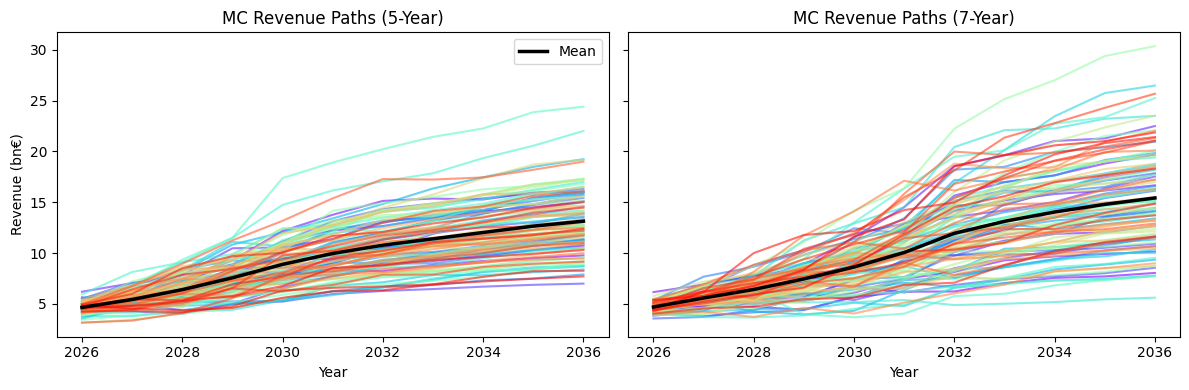

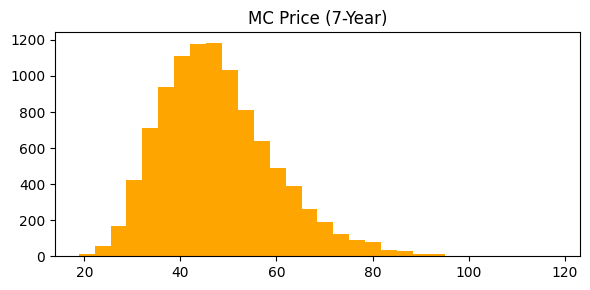

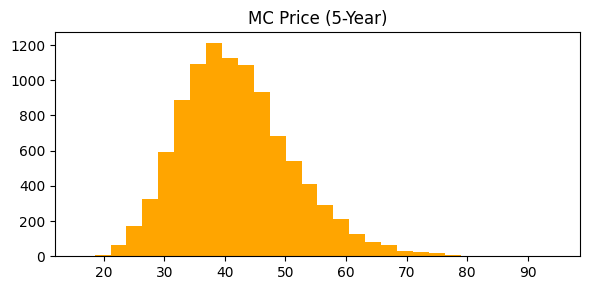

## Monte Carlo Price Quantiles


,7-Year,5-Year
0.01,26.295645,24.408215
0.05,30.990247,28.563233
0.10,33.891939,30.997190
0.25,39.265986,35.387472
0.50,46.474959,40.976493
0.75,54.769797,47.378210
0.90,63.912466,54.147291
0.95,69.958408,58.643652
0.99,81.802171,67.499434


In [15]:
#@title 4) MC Revenue Paths & Price Simulation (volatilità già in 2025)
n_rev_mc = 100
cmap     = plt.cm.rainbow

# Assicuriamoci di partire da Rev2025 = 4.007
rev_start = 4.007

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, (lbl, h) in zip(axs, [('5-Year', 5), ('7-Year', 7)]):
    s      = compute_projection(h)
    # rev_mc[i,j] = revenue simulata per simulazione i nell'anno j (2026+j)
    rev_mc = np.zeros((n_rev_mc, m))

    for i in range(n_rev_mc):
        # primo anno (2026) simulato a partire da Rev2025 con volatilità e crescita g[0], v[0]
        rev_mc[i, 0] = rev_start * (1 + s['g'][0] + s['v'][0] * np.random.randn())
        # anni successivi
        for j in range(1, m):
            rev_mc[i, j] = rev_mc[i, j-1] * (1 + s['g'][j] + s['v'][j] * np.random.randn())

        ax.plot(years, rev_mc[i], color=cmap(i / n_rev_mc), alpha=0.6)

    # aggiungiamo la media
    ax.plot(years, rev_mc.mean(axis=0),
            color='black', linewidth=2.5, label='Mean')
    ax.set_title(f"MC Revenue Paths ({lbl})")
    ax.set_xlabel('Year')

axs[0].set_ylabel('Revenue (bn€)')
axs[0].legend()
plt.tight_layout()
plt.show()


# Price simulation
prices = {}
for lbl, h in [('7-Year', 7), ('5-Year', 5)]:
    s   = compute_projection(h)
    arr = np.zeros(10_000)

    for i in range(arr.size):
        # simulo i-th path
        rev_sim = np.zeros(m)
        rev_sim[0] = rev_start * (1 + s['g'][0] + s['v'][0] * np.random.randn())
        for j in range(1, m):
            rev_sim[j] = rev_sim[j-1] * (1 + s['g'][j] + s['v'][j] * np.random.randn())

        # NOPAT simulato (usiamo OMAT=50%)
        nop_sim = rev_sim * 0.50 * (1 - s['t'])

        # PV dei FCFF dal 2026 (j=0) al 2036 (j=m-1)
        # corrisponde a nop_sim[0..m-1] scontati con df[0..m-1]
        pv_cf = (nop_sim * s['df']).sum()

        # terminal value basato su Rev2036 = rev_sim[-1]
        rev36  = rev_sim[-1]
        fcff37 = rev36 * (1 + rf) * 0.50 * (1 - rf/roic_target) / (0.1- rf)
        pv_tv  = fcff37 * s['df'][-1] / (1.1)

        # equity value → value of equity = PV(CF) + PV(TV) + cash - debt
        arr[i] = (pv_cf + pv_tv + cash - debt) / shares

    prices[lbl] = arr

    plt.figure(figsize=(6, 3))
    plt.hist(arr, bins=30, color='orange')
    plt.title(f"MC Price ({lbl})")
    plt.tight_layout()
    plt.show()


# Quantili
quantiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
df_q = pd.DataFrame(
    {lbl: np.quantile(prices[lbl], quantiles) for lbl in prices},
    index=quantiles
)
print("## Monte Carlo Price Quantiles")
display(df_q)


In [17]:
#@title 4.1) Growth & Volatility Series Check
s5=compute_projection(5); s7=compute_projection(7)
df_gv=pd.DataFrame({'G5':s5['g'],'V5':s5['v'],'G7':s7['g'],'V7':s7['v']},index=years)
print("## Growth & Volatility"); display(df_gv.loc[2026:2036])

## Growth & Volatility


,G5,V5,G7,V7
2026,0.170000,0.127000,0.170000,0.127000
2027,0.170000,0.127000,0.170000,0.127000
2028,0.170000,0.127000,0.170000,0.127000
2029,0.170000,0.127000,0.170000,0.127000
2030,0.170000,0.127000,0.170000,0.127000
2031,0.107150,0.072350,0.170000,0.127000
2032,0.075725,0.045025,0.170000,0.127000
2033,0.060012,0.031363,0.107150,0.072350
2034,0.052156,0.024531,0.075725,0.045025
2035,0.048228,0.021116,0.060012,0.031363


In [21]:
#@title 5) OMAT Sensitivity
fixed_omats = [0.3, 0.4, 0.5, 0.6, 0.7]
res_f, res_c03, res_c05 = [], [], []

# 5a) Fixed OMAT
for om in fixed_omats:
    for lbl, h in [('7-Year', 7), ('5-Year', 5)]:
        s = compute_projection(h, omat=om)
        # includi anche il CF del 2026
        pv_cf = (s['nopat'] * s['df']).sum()
        rev36  = s['rev'][-1]
        fcff37 = rev36 * (1 + rf) * om * (1 - rf/roic_target) / (0.1 - rf)
        pv_tv  = fcff37 * s['df'][-1] / 1.1
        price  = (pv_cf + pv_tv + cash - debt) / shares
        res_f.append([om, lbl, price])

# 5b) Convergent → 0.3
for st in fixed_omats:
    for lbl, h in [('7-Year', 7), ('5-Year', 5)]:
        arr = np.full(m, st)
        arr = converge(arr, 0.5, np.full(m, 0.3), h+1)
        arr[-1] = 0.3
        s = compute_projection(h, omat=arr)
        pv_cf = (s['nopat'] * s['df']).sum()
        rev36  = s['rev'][-1]
        fcff37 = rev36 * (1 + rf) * arr[-1] * (1 - rf/roic_target) / (0.1 - rf)
        pv_tv  = fcff37 * s['df'][-1] / 1.1
        price  = (pv_cf + pv_tv + cash - debt) / shares
        res_c03.append([st, lbl, price])

# 5c) Convergent → 0.5
for st in [0.3, 0.4, 0.5]:
    for lbl, h in [('7-Year', 7), ('5-Year', 5)]:
        arr = np.full(m, st)
        arr = converge(arr, 0.5, np.full(m, 0.5), h+1)
        arr[-1] = 0.5
        s = compute_projection(h, omat=arr)
        pv_cf = (s['nopat'] * s['df']).sum()
        rev36  = s['rev'][-1]
        fcff37 = rev36 * (1 + rf) * arr[-1] * (1 - rf/roic_target) / (0.1 - rf)
        pv_tv  = fcff37 * s['df'][-1] / 1.1
        price  = (pv_cf + pv_tv + cash - debt) / shares
        res_c05.append([st, lbl, price])

# Ricostruisci i DataFrame
df_fixed = (
    pd.DataFrame(res_f, columns=['OMAT', 'Scenario', 'Price'])
      .pivot(index='OMAT', columns='Scenario', values='Price')
)
df_c03 = (
    pd.DataFrame(res_c03, columns=['OMAT', 'Scenario', 'Price'])
      .pivot(index='OMAT', columns='Scenario', values='Price')
)
df_c05 = (
    pd.DataFrame(res_c05, columns=['OMAT', 'Scenario', 'Price'])
      .pivot(index='OMAT', columns='Scenario', values='Price')
)

print("## Fixed OM Price/share")
display(df_fixed)
print("## Convergent → 0.3 Price/share")
display(df_c03)
print("## Convergent → 0.5 Price/share")
display(df_c05)


## Fixed OM Price/share


Scenario,5-Year,7-Year
OMAT,,
0.3,26.065980,29.606008
0.4,33.979468,38.699506
0.5,41.892956,47.793003
0.6,49.806444,56.886500
0.7,57.719932,65.979998


## Convergent → 0.3 Price/share


Scenario,5-Year,7-Year
OMAT,,
0.3,26.065980,29.606008
0.4,28.715456,33.135958
0.5,31.364931,36.665908
0.6,34.014407,40.195857
0.7,36.663883,43.725807


## Convergent → 0.5 Price/share


Scenario,5-Year,7-Year
OMAT,,
0.3,36.594005,40.733104
0.4,39.243481,44.263053
0.5,41.892956,47.793003


In [19]:
#@title 5.1) Debug Table (2026–2036) con ROIC₍₂₀₂₆₎
for h,label in [(5,'5-Year'),(7,'7-Year')]:
    print(f"### Debug {label}")
    scenarios = {}
    # definizione scenari OMAT come prima
    for om in fixed_omats:            scenarios[f'Fix{om:.1f}'] = np.full(m, om)
    for st in fixed_omats:
        arr = np.full(m,st)
        arr = converge(arr,0.5,np.full(m,0.3),h+1); arr[-1]=0.3
        scenarios[f'{st:.1f}→0.3'] = arr
    for st in [0.3,0.4,0.5]:
        arr = np.full(m,st)
        arr = converge(arr,0.5,np.full(m,0.5),h+1); arr[-1]=0.5
        scenarios[f'{st:.1f}→0.5'] = arr

    # calcolo pesi per CapRD storico
    w_cap = [(n_rd - k)/n_rd for k in range(n_rd+1)]
    # calcolo CapRD_2025
    caprd_25 = sum(w_cap[k] * hist_rd[-1-k] for k in range(len(hist_rd)))

    # IC iniziale a inizio 2026
    IC_25 = (equity - cash + debt) + caprd_25

    for name,omat in scenarios.items():
        s    = compute_rd_series(h, omat_pre_tax=omat)
        # ROIC: vogliamo includere anche il 2026
        roic = np.full(m, np.nan)
        # primo anno: AdjNOPAT[0] / IC_25
        roic[0] = s['adj_nopat'][0] / IC_25 * 100
        # gli altri anni come prima
        roic[1:] = s['adj_nopat'][1:] / s['ic'][:-1] * 100

        df = pd.DataFrame({
            'OMAT': omat,
            'R&D%': s['rd_pct'],
            'NOPAT': s['adj_nopat'],
            'R&D': s['rd'],
            'IC': s['ic'],
            'ROIC': roic
        }, index=years).loc[2026:2036]

        print(name)
        display(df)
    print()


### Debug 5-Year
Fix0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.3,0.350000,2.207478,1.640866,11.385712,21.424751
2027,0.3,0.350000,2.537526,1.919814,12.582885,22.286936
2028,0.3,0.350000,2.923683,2.246182,13.938355,23.235396
2029,0.3,0.350000,3.375487,2.628033,15.479031,24.217254
2030,0.3,0.350000,3.904097,3.074799,17.236401,25.221842
2031,0.3,0.200000,2.575373,1.945293,17.595079,14.941478
2032,0.3,0.125000,2.012643,1.307875,17.134185,11.438668
2033,0.3,0.087500,1.804052,0.970455,16.266999,10.528963
2034,0.3,0.068750,1.799628,0.802270,15.229573,11.063064
2035,0.3,0.059375,1.984829,0.726285,14.226479,13.032728


Fix0.4


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.4,0.300000,2.395005,1.406457,11.151303,23.244807
2027,0.4,0.300000,2.780375,1.645555,12.097657,24.933182
2028,0.4,0.300000,3.231257,1.925299,13.183111,26.709771
2029,0.4,0.300000,3.758789,2.252600,14.431309,28.512152
2030,0.4,0.300000,4.376001,2.635542,15.869920,30.322965
2031,0.4,0.175000,3.323385,1.702132,16.149861,20.941411
2032,0.4,0.112500,2.959951,1.177088,15.746920,18.328027
2033,0.4,0.081250,2.879281,0.901137,15.012234,18.284723
2034,0.4,0.065625,2.963809,0.765803,14.147093,19.742627
2035,0.4,0.057812,3.217848,0.707172,13.337284,22.745648


Fix0.5


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.5,0.25000,2.582533,1.172047,10.916893,25.064862
2027,0.5,0.25000,3.023223,1.371296,11.612430,27.693070
2028,0.5,0.25000,3.538830,1.604416,12.427867,30.474501
2029,0.5,0.25000,4.142090,1.877167,13.383587,33.329054
2030,0.5,0.25000,4.847905,2.196285,14.503439,36.222762
2031,0.5,0.15000,4.071397,1.458970,14.704643,28.071944
2032,0.5,0.10000,3.907259,1.046300,14.359654,26.571600
2033,0.5,0.07500,3.954509,0.831819,13.757470,27.539028
2034,0.5,0.06250,4.127990,0.729336,13.064612,30.005448
2035,0.5,0.05625,4.450867,0.688059,12.448089,34.068113


Fix0.6


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.6,0.200,2.770061,0.937638,10.682484,26.884918
2027,0.6,0.200,3.266071,1.097036,11.127202,30.574080
2028,0.6,0.200,3.846403,1.283533,11.672623,34.567570
2029,0.6,0.200,4.525392,1.501733,12.335865,38.769283
2030,0.6,0.200,5.319809,1.757028,13.136959,43.124734
2031,0.6,0.120,4.770777,1.167176,13.210792,36.315691
2032,0.6,0.080,4.780958,0.837040,12.850148,36.189788
2033,0.6,0.060,4.945403,0.665455,12.296129,38.485184
2034,0.6,0.050,5.205186,0.583469,11.688570,42.331909
2035,0.6,0.045,5.598742,0.550448,11.180187,47.899289


Fix0.7


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.7,0.15000,2.957588,0.703229,10.448074,28.704973
2027,0.7,0.15000,3.508919,0.822777,10.641974,33.584365
2028,0.7,0.15000,4.153977,0.962649,10.917379,39.033892
2029,0.7,0.15000,4.908694,1.126300,11.288143,44.962203
2030,0.7,0.15000,5.791713,1.317771,11.770478,51.307935
2031,0.7,0.09000,5.470157,0.875382,11.716942,46.473534
2032,0.7,0.06000,5.654657,0.627780,11.340641,48.260515
2033,0.7,0.04500,5.936297,0.499091,10.834788,52.345337
2034,0.7,0.03750,6.282382,0.437602,10.312528,57.983431
2035,0.7,0.03375,6.746617,0.412836,9.912286,65.421563


0.3→0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.3,0.350000,2.207478,1.640866,11.385712,21.424751
2027,0.3,0.350000,2.537526,1.919814,12.582885,22.286936
2028,0.3,0.350000,2.923683,2.246182,13.938355,23.235396
2029,0.3,0.350000,3.375487,2.628033,15.479031,24.217254
2030,0.3,0.350000,3.904097,3.074799,17.236401,25.221842
2031,0.3,0.200000,2.575373,1.945293,17.595079,14.941478
2032,0.3,0.125000,2.012643,1.307875,17.134185,11.438668
2033,0.3,0.087500,1.804052,0.970455,16.266999,10.528963
2034,0.3,0.068750,1.799628,0.802270,15.229573,11.063064
2035,0.3,0.059375,1.984829,0.726285,14.226479,13.032728


0.4→0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.40000,0.300000,2.395005,1.406457,11.151303,23.244807
2027,0.40000,0.300000,2.780375,1.645555,12.097657,24.933182
2028,0.40000,0.300000,3.231257,1.925299,13.183111,26.709771
2029,0.40000,0.300000,3.758789,2.252600,14.431309,28.512152
2030,0.40000,0.300000,4.376001,2.635542,15.869920,30.322965
2031,0.40000,0.175000,3.323385,1.702132,16.149861,20.941411
2032,0.35000,0.112500,2.515273,1.177088,15.746920,15.574581
2033,0.32500,0.081250,2.172235,0.901137,15.012234,13.794665
2034,0.31250,0.065625,2.095900,0.765803,14.147093,13.961277
2035,0.30625,0.057812,2.243097,0.707172,13.337284,15.855534


0.5→0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.5000,0.25000,2.582533,1.172047,10.916893,25.064862
2027,0.5000,0.25000,3.023223,1.371296,11.612430,27.693070
2028,0.5000,0.25000,3.538830,1.604416,12.427867,30.474501
2029,0.5000,0.25000,4.142090,1.877167,13.383587,33.329054
2030,0.5000,0.25000,4.847905,2.196285,14.503439,36.222762
2031,0.5000,0.15000,4.071397,1.458970,14.704643,28.071944
2032,0.4000,0.10000,3.017904,1.046300,14.359654,20.523474
2033,0.3500,0.07500,2.540418,0.831819,13.757470,17.691357
2034,0.3250,0.06250,2.392171,0.729336,13.064612,17.388160
2035,0.3125,0.05625,2.501365,0.688059,12.448089,19.146112


0.6→0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.60000,0.200,2.770061,0.937638,10.682484,26.884918
2027,0.60000,0.200,3.266071,1.097036,11.127202,30.574080
2028,0.60000,0.200,3.846403,1.283533,11.672623,34.567570
2029,0.60000,0.200,4.525392,1.501733,12.335865,38.769283
2030,0.60000,0.200,5.319809,1.757028,13.136959,43.124734
2031,0.60000,0.120,4.770777,1.167176,13.210792,36.315691
2032,0.45000,0.080,3.446925,0.837040,12.850148,26.091734
2033,0.37500,0.060,2.824265,0.665455,12.296129,21.978467
2034,0.33750,0.050,2.601457,0.583469,11.688570,21.156714
2035,0.31875,0.045,2.674490,0.550448,11.180187,22.881238


0.7→0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.700,0.15000,2.957588,0.703229,10.448074,28.704973
2027,0.700,0.15000,3.508919,0.822777,10.641974,33.584365
2028,0.700,0.15000,4.153977,0.962649,10.917379,39.033892
2029,0.700,0.15000,4.908694,1.126300,11.288143,44.962203
2030,0.700,0.15000,5.791713,1.317771,11.770478,51.307935
2031,0.700,0.09000,5.470157,0.875382,11.716942,46.473534
2032,0.500,0.06000,3.875946,0.627780,11.340641,33.079843
2033,0.400,0.04500,3.108113,0.499091,10.834788,27.406858
2034,0.350,0.03750,2.810743,0.437602,10.312528,25.941834
2035,0.325,0.03375,2.847614,0.412836,9.912286,27.613149


0.3→0.5


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.3000,0.350000,2.207478,1.640866,11.385712,21.424751
2027,0.3000,0.350000,2.537526,1.919814,12.582885,22.286936
2028,0.3000,0.350000,2.923683,2.246182,13.938355,23.235396
2029,0.3000,0.350000,3.375487,2.628033,15.479031,24.217254
2030,0.3000,0.350000,3.904097,3.074799,17.236401,25.221842
2031,0.3000,0.200000,2.575373,1.945293,17.595079,14.941478
2032,0.4000,0.125000,2.901998,1.307875,17.134185,16.493236
2033,0.4500,0.087500,3.218144,0.970455,16.266999,18.782006
2034,0.4750,0.068750,3.535448,0.802270,15.229573,21.733868
2035,0.4875,0.059375,3.934330,0.726285,14.226479,25.833492


0.4→0.5


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.40000,0.300000,2.395005,1.406457,11.151303,23.244807
2027,0.40000,0.300000,2.780375,1.645555,12.097657,24.933182
2028,0.40000,0.300000,3.231257,1.925299,13.183111,26.709771
2029,0.40000,0.300000,3.758789,2.252600,14.431309,28.512152
2030,0.40000,0.300000,4.376001,2.635542,15.869920,30.322965
2031,0.40000,0.175000,3.323385,1.702132,16.149861,20.941411
2032,0.45000,0.112500,3.404628,1.177088,15.746920,21.081472
2033,0.47500,0.081250,3.586326,0.901137,15.012234,22.774781
2034,0.48750,0.065625,3.831719,0.765803,14.147093,25.523977
2035,0.49375,0.057812,4.192599,0.707172,13.337284,29.635762


0.5→0.5


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.5,0.25000,2.582533,1.172047,10.916893,25.064862
2027,0.5,0.25000,3.023223,1.371296,11.612430,27.693070
2028,0.5,0.25000,3.538830,1.604416,12.427867,30.474501
2029,0.5,0.25000,4.142090,1.877167,13.383587,33.329054
2030,0.5,0.25000,4.847905,2.196285,14.503439,36.222762
2031,0.5,0.15000,4.071397,1.458970,14.704643,28.071944
2032,0.5,0.10000,3.907259,1.046300,14.359654,26.571600
2033,0.5,0.07500,3.954509,0.831819,13.757470,27.539028
2034,0.5,0.06250,4.127990,0.729336,13.064612,30.005448
2035,0.5,0.05625,4.450867,0.688059,12.448089,34.068113



### Debug 7-Year
Fix0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.3,0.3500,2.207478,1.640866,11.385712,21.424751
2027,0.3,0.3500,2.537526,1.919814,12.582885,22.286936
2028,0.3,0.3500,2.923683,2.246182,13.938355,23.235396
2029,0.3,0.3500,3.375487,2.628033,15.479031,24.217254
2030,0.3,0.3500,3.904097,3.074799,17.236401,25.221842
2031,0.3,0.3500,4.522571,3.597515,19.247300,26.238486
2032,0.3,0.3500,5.327585,4.209092,21.636229,27.679649
2033,0.3,0.2000,3.608195,2.662912,22.209991,16.676635
2034,0.3,0.1250,2.839745,1.790351,21.663711,12.785890
2035,0.3,0.0875,2.615900,1.328456,20.622953,12.075030


Fix0.4


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.4,0.30000,2.395005,1.406457,11.151303,23.244807
2027,0.4,0.30000,2.780375,1.645555,12.097657,24.933182
2028,0.4,0.30000,3.231257,1.925299,13.183111,26.709771
2029,0.4,0.30000,3.758789,2.252600,14.431309,28.512152
2030,0.4,0.30000,4.376001,2.635542,15.869920,30.322965
2031,0.4,0.30000,5.098139,3.083584,17.531313,32.124543
2032,0.4,0.30000,6.024441,3.607793,19.534761,34.363891
2033,0.4,0.17500,4.683016,2.330048,20.051605,23.972732
2034,0.4,0.11250,4.187382,1.611316,19.635524,20.883025
2035,0.4,0.08125,4.138647,1.233566,18.827013,21.077344


Fix0.5


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.5,0.250,2.582533,1.172047,10.916893,25.064862
2027,0.5,0.250,3.023223,1.371296,11.612430,27.693070
2028,0.5,0.250,3.538830,1.604416,12.427867,30.474501
2029,0.5,0.250,4.142090,1.877167,13.383587,33.329054
2030,0.5,0.250,4.847905,2.196285,14.503439,36.222762
2031,0.5,0.250,5.673708,2.569653,15.815326,39.119742
2032,0.5,0.250,6.721298,3.006494,17.433292,42.498635
2033,0.5,0.150,5.757837,1.997184,17.893220,33.027821
2034,0.5,0.100,5.535019,1.432281,17.607337,30.933610
2035,0.5,0.075,5.661394,1.138676,17.031074,32.153608


Fix0.6


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.6,0.20,2.770061,0.937638,10.682484,26.884918
2027,0.6,0.20,3.266071,1.097036,11.127202,30.574080
2028,0.6,0.20,3.846403,1.283533,11.672623,34.567570
2029,0.6,0.20,4.525392,1.501733,12.335865,38.769283
2030,0.6,0.20,5.319809,1.757028,13.136959,43.124734
2031,0.6,0.20,6.249277,2.055723,14.099339,47.570193
2032,0.6,0.20,7.418154,2.405195,15.331824,52.613488
2033,0.6,0.12,6.766085,1.597747,15.668262,44.130984
2034,0.6,0.08,6.781892,1.145824,15.411814,43.284266
2035,0.6,0.06,7.068695,0.910941,14.952351,45.865435


Fix0.7


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.7,0.150,2.957588,0.703229,10.448074,28.704973
2027,0.7,0.150,3.508919,0.822777,10.641974,33.584365
2028,0.7,0.150,4.153977,0.962649,10.917379,39.033892
2029,0.7,0.150,4.908694,1.126300,11.288143,44.962203
2030,0.7,0.150,5.791713,1.317771,11.770478,51.307935
2031,0.7,0.150,6.824845,1.541792,12.383352,57.982737
2032,0.7,0.150,8.115010,1.803897,13.230355,65.531614
2033,0.7,0.090,7.774333,1.198310,13.443303,58.761330
2034,0.7,0.060,8.028765,0.859368,13.216290,59.723157
2035,0.7,0.045,8.475997,0.683206,12.873629,64.132948


0.3→0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.3,0.3500,2.207478,1.640866,11.385712,21.424751
2027,0.3,0.3500,2.537526,1.919814,12.582885,22.286936
2028,0.3,0.3500,2.923683,2.246182,13.938355,23.235396
2029,0.3,0.3500,3.375487,2.628033,15.479031,24.217254
2030,0.3,0.3500,3.904097,3.074799,17.236401,25.221842
2031,0.3,0.3500,4.522571,3.597515,19.247300,26.238486
2032,0.3,0.3500,5.327585,4.209092,21.636229,27.679649
2033,0.3,0.2000,3.608195,2.662912,22.209991,16.676635
2034,0.3,0.1250,2.839745,1.790351,21.663711,12.785890
2035,0.3,0.0875,2.615900,1.328456,20.622953,12.075030


0.4→0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.400,0.30000,2.395005,1.406457,11.151303,23.244807
2027,0.400,0.30000,2.780375,1.645555,12.097657,24.933182
2028,0.400,0.30000,3.231257,1.925299,13.183111,26.709771
2029,0.400,0.30000,3.758789,2.252600,14.431309,28.512152
2030,0.400,0.30000,4.376001,2.635542,15.869920,30.322965
2031,0.400,0.30000,5.098139,3.083584,17.531313,32.124543
2032,0.400,0.30000,6.024441,3.607793,19.534761,34.363891
2033,0.400,0.17500,4.683016,2.330048,20.051605,23.972732
2034,0.350,0.11250,3.578663,1.611316,19.635524,17.847262
2035,0.325,0.08125,3.170772,1.233566,18.827013,16.148140


0.5→0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.50,0.250,2.582533,1.172047,10.916893,25.064862
2027,0.50,0.250,3.023223,1.371296,11.612430,27.693070
2028,0.50,0.250,3.538830,1.604416,12.427867,30.474501
2029,0.50,0.250,4.142090,1.877167,13.383587,33.329054
2030,0.50,0.250,4.847905,2.196285,14.503439,36.222762
2031,0.50,0.250,5.673708,2.569653,15.815326,39.119742
2032,0.50,0.250,6.721298,3.006494,17.433292,42.498635
2033,0.50,0.150,5.757837,1.997184,17.893220,33.027821
2034,0.40,0.100,4.317580,1.432281,17.607337,24.129700
2035,0.35,0.075,3.725644,1.138676,17.031074,21.159612


0.6→0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.600,0.20,2.770061,0.937638,10.682484,26.884918
2027,0.600,0.20,3.266071,1.097036,11.127202,30.574080
2028,0.600,0.20,3.846403,1.283533,11.672623,34.567570
2029,0.600,0.20,4.525392,1.501733,12.335865,38.769283
2030,0.600,0.20,5.319809,1.757028,13.136959,43.124734
2031,0.600,0.20,6.249277,2.055723,14.099339,47.570193
2032,0.600,0.20,7.418154,2.405195,15.331824,52.613488
2033,0.600,0.12,6.766085,1.597747,15.668262,44.130984
2034,0.450,0.08,4.955734,1.145824,15.411814,31.629127
2035,0.375,0.06,4.165070,0.910941,14.952351,27.025180


0.7→0.3


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.7,0.150,2.957588,0.703229,10.448074,28.704973
2027,0.7,0.150,3.508919,0.822777,10.641974,33.584365
2028,0.7,0.150,4.153977,0.962649,10.917379,39.033892
2029,0.7,0.150,4.908694,1.126300,11.288143,44.962203
2030,0.7,0.150,5.791713,1.317771,11.770478,51.307935
2031,0.7,0.150,6.824845,1.541792,12.383352,57.982737
2032,0.7,0.150,8.115010,1.803897,13.230355,65.531614
2033,0.7,0.090,7.774333,1.198310,13.443303,58.761330
2034,0.5,0.060,5.593888,0.859368,13.216290,41.610965
2035,0.4,0.045,4.604497,0.683206,12.873629,34.839554


0.3→0.5


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.30,0.3500,2.207478,1.640866,11.385712,21.424751
2027,0.30,0.3500,2.537526,1.919814,12.582885,22.286936
2028,0.30,0.3500,2.923683,2.246182,13.938355,23.235396
2029,0.30,0.3500,3.375487,2.628033,15.479031,24.217254
2030,0.30,0.3500,3.904097,3.074799,17.236401,25.221842
2031,0.30,0.3500,4.522571,3.597515,19.247300,26.238486
2032,0.30,0.3500,5.327585,4.209092,21.636229,27.679649
2033,0.30,0.2000,3.608195,2.662912,22.209991,16.676635
2034,0.40,0.1250,4.057183,1.790351,21.663711,18.267380
2035,0.45,0.0875,4.551650,1.328456,20.622953,21.010479


0.4→0.5


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.400,0.30000,2.395005,1.406457,11.151303,23.244807
2027,0.400,0.30000,2.780375,1.645555,12.097657,24.933182
2028,0.400,0.30000,3.231257,1.925299,13.183111,26.709771
2029,0.400,0.30000,3.758789,2.252600,14.431309,28.512152
2030,0.400,0.30000,4.376001,2.635542,15.869920,30.322965
2031,0.400,0.30000,5.098139,3.083584,17.531313,32.124543
2032,0.400,0.30000,6.024441,3.607793,19.534761,34.363891
2033,0.400,0.17500,4.683016,2.330048,20.051605,23.972732
2034,0.450,0.11250,4.796101,1.611316,19.635524,23.918789
2035,0.475,0.08125,5.106522,1.233566,18.827013,26.006547


0.5→0.5


,OMAT,R&D%,NOPAT,R&D,IC,ROIC
2026,0.5,0.250,2.582533,1.172047,10.916893,25.064862
2027,0.5,0.250,3.023223,1.371296,11.612430,27.693070
2028,0.5,0.250,3.538830,1.604416,12.427867,30.474501
2029,0.5,0.250,4.142090,1.877167,13.383587,33.329054
2030,0.5,0.250,4.847905,2.196285,14.503439,36.222762
2031,0.5,0.250,5.673708,2.569653,15.815326,39.119742
2032,0.5,0.250,6.721298,3.006494,17.433292,42.498635
2033,0.5,0.150,5.757837,1.997184,17.893220,33.027821
2034,0.5,0.100,5.535019,1.432281,17.607337,30.933610
2035,0.5,0.075,5.661394,1.138676,17.031074,32.153608


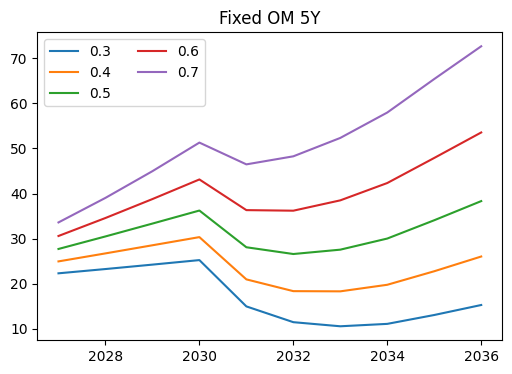

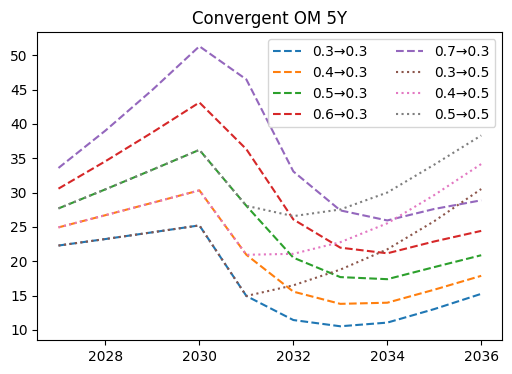

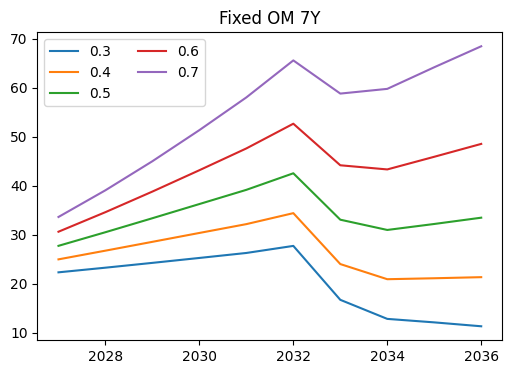

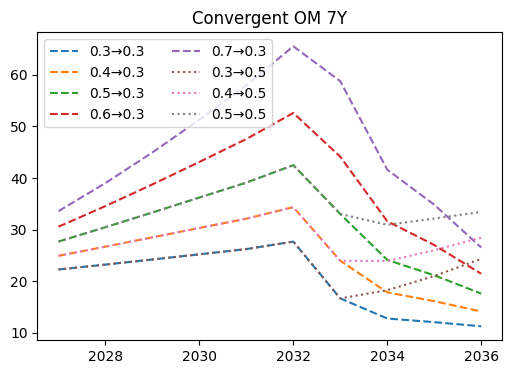

In [20]:
#@title 6) Adjusted ROIC Charts (to 2036)
for h,label in [(5,'5Y'),(7,'7Y')]:
    plt.figure(figsize=(6,4))
    for om in fixed_omats:
        s=compute_rd_series(h,omat_pre_tax=om)
        plt.plot(years[1:],s['adj_roic'][1:]*100,label=f'{om:.1f}')
    plt.title(f'Fixed OM {label}'); plt.legend(ncol=2); plt.show()
    plt.figure(figsize=(6,4))
    for st in fixed_omats:
        arr=np.full(m,st); arr=converge(arr,0.5,np.full(m,0.3),h+1); arr[-1]=0.3
        s=compute_rd_series(h,omat_pre_tax=arr)
        plt.plot(years[1:],s['adj_roic'][1:]*100,'--',label=f'{st:.1f}→0.3')
    for st in [0.3,0.4,0.5]:
        arr=np.full(m,st); arr=converge(arr,0.5,np.full(m,0.5),h+1); arr[-1]=0.5
        s=compute_rd_series(h,omat_pre_tax=arr)
        plt.plot(years[1:],s['adj_roic'][1:]*100,':',label=f'{st:.1f}→0.5')
    plt.title(f'Convergent OM {label}'); plt.legend(ncol=2); plt.show()